In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Train.csv has the Field_IDs needed to find the npy files
train = pd.read_csv('Train.csv')
print(train.shape)
train.head()

(2977, 4)


,Field_ID,Year,Quality,Yield
0,MH2O0YH,2019,3,3.686
1,O9TURWL,2019,2,5.657
2,35AFSDD,2019,3,3.082
3,PM05EG9,2019,2,2.707
4,V7PZBCG,2019,2,2.679


In [3]:
test = pd.read_csv('test_field_ids_with_year.csv')
print(test.shape)
test.head()

(1055, 2)


,Field_ID,Year
0,E9UZCEA,2019
1,1WGGS1Q,2019
2,EG2KXE2,2019
3,HC3GQXF,2019
4,7AK6GFK,2019


<AxesSubplot:>

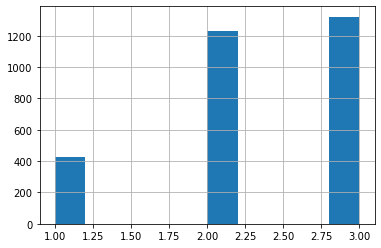

In [4]:
train.Quality.hist()

In [5]:
train = train.loc[train.Quality > 1]

In [6]:
band_names = [l.strip() for l in open('bandnames.txt', 'r').readlines()]

In [7]:
data  = pd.concat([train, test], axis=0)

# View data file

Array shape: (360, 41, 41)


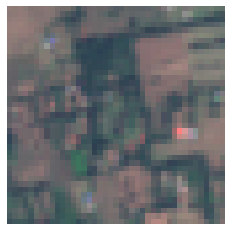

In [8]:
# Look at a sample:
fid = 'PM05EG9'
fn = f'image_arrays/{fid}.npy' # File name based on Field_ID
arr = np.load(fn) # Loading the data with numpy
print('Array shape:', arr.shape) # 360 bands, images 40 or 41px a side
rgb_jan = np.stack([arr[3], arr[2], arr[1]], axis=-1) # Combine three bands for viewing
rgb_jan = rgb_jan / np.max(rgb_jan) # Scale band values to (0, 1) for easy image display
plt.imshow(rgb_jan, vmin=0, vmax=1) # View
plt.axis('off');

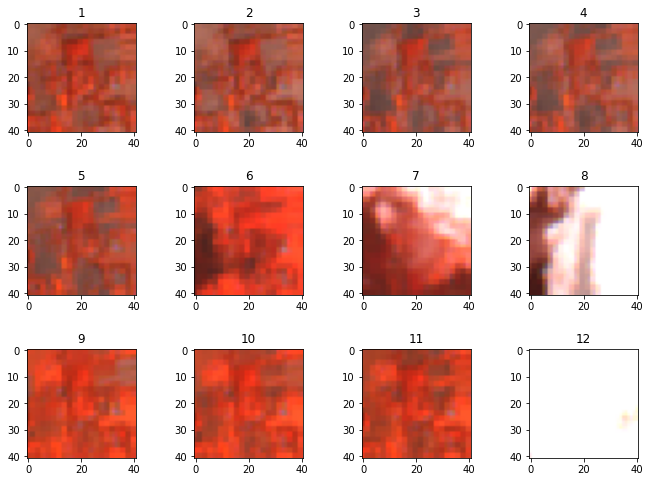

In [9]:
# View false colour images from each month in the year:
fig, axs = plt.subplots(3, 4, figsize=(12, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(12):
    rgb = np.stack([arr[i*30 + 8], arr[i*30 + 4], arr[i*30 + 3]], axis=-1) # False colour (band 8, 4 and 3)
    rgb = rgb / 4000 # Scaling consistently 
    axs[i].imshow(rgb.clip(0, 1))
    axs[i].set_title(str(i+1))

# Train data

In [10]:
def process_im(fid, folder='image_arrays', bands_of_interest = ['S2_B03', 'S2_B04', 'S2_B05', 'S2_B06', 'S2_B07', 'S2_B08', 'S2_B8A', 'S2_B09', 'S2_B10', 'S2_B11', 'S2_B12', 'S2_QA60']):
    fn = f'{folder}/{fid}.npy'
    arr = np.load(fn)
    values = {}
    for month in range(12):
        bns = [str(month) + '_' + b for b in bands_of_interest] # Bands of interest for this month 
        idxs = np.where(np.isin(band_names, bns)) # Index of these bands
        vs = arr[idxs, 5, 5] # Sample the im at the center point
        for bn, v in zip(bns, vs[0]):
            values[bn] = v
    return values

In [11]:
spectral_data = pd.DataFrame([process_im(fid, bands_of_interest= ['S2_B01', 'S2_B02', 'S2_B03', 'S2_B04', 'S2_B05', 'S2_B06', 'S2_B07', 'S2_B08', 'S2_B8A', 'S2_B09', 'S2_B10', 'S2_B11', 'S2_B12']) for fid in data['Field_ID'].values])
# Add in the field ID and yield
spectral_data['Field_ID'] = data['Field_ID'].values
spectral_data['Yield'] = data['Yield'].values
spectral_data['Year'] = data['Year'].values

In [12]:
mask_data = pd.DataFrame([process_im(fid, bands_of_interest= ['S2_QA60']) for fid in data['Field_ID'].values])

In [13]:
## fill cloud data with year mean
bands_list = ['S2_B01', 'S2_B02', 'S2_B03', 'S2_B04', 'S2_B05', 'S2_B06', 'S2_B07', 'S2_B08', 'S2_B8A', 'S2_B09', 'S2_B10', 'S2_B11', 'S2_B12']

for element in bands_list:
    target_list = []
    for month in range(12):
        target_list.append(str(month)+'_'+element) # form list of 1 band for 12 months
    spectral_values = spectral_data[target_list].values
    row_mean = np.nanmean(np.where(mask_data.values==0, spectral_values, np.nan), axis = 1) # row mean without clouds
    inds = np.where(mask_data.values>0) # indicies to replace with mean
    spectral_values[inds] = np.take(row_mean, inds[0])
    spectral_data[target_list] = spectral_values    

## Vegetation indicies

In [14]:
# calculate NDVI
for month in range(12):
    spectral_data[str(month)+'_NDVI'] = (spectral_data[str(month)+'_S2_B08'] - spectral_data[str(month)+'_S2_B04']) / (spectral_data[str(month)+'_S2_B08'] + spectral_data[str(month)+'_S2_B04'])

In [15]:
# calculate ATSAVI
for month in range(12):
    spectral_data[str(month)+'_ATSAVI'] = 1.22*(spectral_data[str(month)+'_S2_B09'] - 1.22*spectral_data[str(month)+'_S2_B05'])/(1.22*spectral_data[str(month)+'_S2_B09']+spectral_data[str(month)+'_S2_B05']-1.22*0.03+0.08*(1+1.22**2))

In [16]:
# calculate ARVI2
for month in range(12):
    spectral_data[str(month)+'_ARVI2'] = -0.18+1.17*(spectral_data[str(month)+'_S2_B09'] - spectral_data[str(month)+'_S2_B04']) / (spectral_data[str(month)+'_S2_B09'] + spectral_data[str(month)+'_S2_B04'])

In [17]:
# calculate GARI
for month in range(12):
    spectral_data[str(month)+'_GARI'] = spectral_data[str(month)+'_S2_B09'] - (spectral_data[str(month)+'_S2_B03'] - (spectral_data[str(month)+'_S2_B01'] - spectral_data[str(month)+'_S2_B05'])) / spectral_data[str(month)+'_S2_B09']     - (spectral_data[str(month)+'_S2_B03'] + (spectral_data[str(month)+'_S2_B01'] - spectral_data[str(month)+'_S2_B05'])) 

In [18]:
# calculate CIrededge
for month in range(12):
    spectral_data[str(month)+'_CIrededge'] = (spectral_data[str(month)+'_S2_B09']/spectral_data[str(month)+'_S2_B05'])-1

In [19]:
# calculate CVI
for month in range(12):
    spectral_data[str(month)+'_CVI'] = spectral_data[str(month)+'_S2_B09']*spectral_data[str(month)+'_S2_B05']/ (spectral_data[str(month)+'_S2_B03'])

In [20]:
# calculate LCI
for month in range(12):
    spectral_data[str(month)+'_LCI'] = (spectral_data[str(month)+'_S2_B08'] - spectral_data[str(month)+'_S2_B05']) / (spectral_data[str(month)+'_S2_B08'] + spectral_data[str(month)+'_S2_B04'])

In [21]:
# calculate MVI
for month in range(12):
    spectral_data[str(month)+'_MVI'] = spectral_data[str(month)+'_S2_B09'] / spectral_data[str(month)+'_S2_B11']

In [22]:
# calculate mARI
for month in range(12):
    spectral_data[str(month)+'_mARI'] = (1/spectral_data[str(month)+'_S2_B03'] - 1/spectral_data[str(month)+'_S2_B05'])*spectral_data[str(month)+'_S2_B09']

/tmp/ipykernel_4234/1320651392.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  spectral_data[str(month)+'_mARI'] = (1/spectral_data[str(month)+'_S2_B03'] - 1/spectral_data[str(month)+'_S2_B05'])*spectral_data[str(month)+'_S2_B09']


In [23]:
# calculate NDRE
for month in range(12):
    spectral_data[str(month)+'_NDRE'] = (spectral_data[str(month)+'_S2_B09'] - spectral_data[str(month)+'_S2_B05']) / (spectral_data[str(month)+'_S2_B09'] + spectral_data[str(month)+'_S2_B05'])

/tmp/ipykernel_4234/2447069102.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  spectral_data[str(month)+'_NDRE'] = (spectral_data[str(month)+'_S2_B09'] - spectral_data[str(month)+'_S2_B05']) / (spectral_data[str(month)+'_S2_B09'] + spectral_data[str(month)+'_S2_B05'])


In [24]:
climate_data = pd.DataFrame([process_im(fid, bands_of_interest= ['CLIM_aet', 'CLIM_def', 'CLIM_pdsi', 'CLIM_pet', 'CLIM_pr', 'CLIM_ro', 'CLIM_soil', 'CLIM_srad', 'CLIM_swe', 'CLIM_tmmn', 'CLIM_tmmx', 'CLIM_vap', 'CLIM_vpd', 'CLIM_vs']) for fid in data['Field_ID'].values])
# Add in the field ID and yield
climate_data['Field_ID'] = data['Field_ID'].values
climate_data['Yield'] = data['Yield'].values
climate_data['Year'] = data['Year'].values

In [25]:
merged_data = pd.merge(spectral_data, climate_data, how = 'outer',  on = ['Field_ID', 'Yield', 'Year'])

# Stat from features

In [26]:
target_cols = [
    'S2_B01', 'S2_B02', 'S2_B03', 'S2_B04', 'S2_B05', 'S2_B06', 'S2_B07', 'S2_B08', 'S2_B8A', 'S2_B09', 'S2_B10', 'S2_B11', 'S2_B12',
    'NDVI', 'ATSAVI', 'ARVI2', 'GARI', 'CIrededge', 'CVI', 'LCI', 'MVI', 'mARI', 'NDRE',
    'CLIM_aet',  'CLIM_pet', 'CLIM_pr', 'CLIM_soil', 'CLIM_srad','CLIM_tmmn', 'CLIM_tmmx', 'CLIM_vap', 'CLIM_vpd', 'CLIM_vs'
]

In [27]:
def find_monthly_features(df, feature, month):
    selected_features = []
    for m in range(month):
        selected_features+=[f for f in df.columns if (f.split('_')[0]==str(m)) and (feature in f) and ('MIN' not in f) and ('MEAN' not in f) and ('MAX' not in f)]
    return selected_features

In [28]:
for month in range(1, 12):
    for col in target_cols:
        selected_cols = find_monthly_features(merged_data, col, month)
        
        field_min = '_'.join([str(month), col, 'MIN'])
        field_mean = '_'.join([str(month), col, 'MEAN'])
        field_max = '_'.join([str(month), col, 'MAX'])
        
        merged_data[field_min] = np.nanmin(merged_data[selected_cols], axis=1)
        merged_data[field_mean] = np.nanmean(merged_data[selected_cols], axis=1)
        merged_data[field_max] = np.nanmax(merged_data[selected_cols], axis=1)

# Soil properties

In [29]:
additional_info = pd.read_csv('fields_w_additional_info.csv')
soils_cols = [col for col in additional_info.columns if 'soil_' in col]
soils = additional_info[['Field_ID']+soils_cols]

In [30]:
#just to make names shorter
soils = soils.rename(columns={
    'soil_bdod_5-15cm_mean':'BDOD',
    'soil_cec_5-15cm_mean':'CEC',
    'soil_cfvo_5-15cm_mean':'CFVO',
    'soil_clay_5-15cm_mean': 'CLAY',
    'soil_nitrogen_5-15cm_mean':'NITR',
    'soil_ocd_5-15cm_mean':'OCD',
    'soil_ocs_0-30cm_mean':'OCS',
    'soil_phh2o_5-15cm_mean': 'PHH2O',
    'soil_sand_5-15cm_mean':'SAND',
    'soil_silt_5-15cm_mean':'SILT',
    'soil_soc_5-15cm_mean':'SOC'
})

In [31]:
merged_data = pd.merge(merged_data, soils, how='left')

# Study data

In [32]:
merged_data.shape

(3607, 1547)

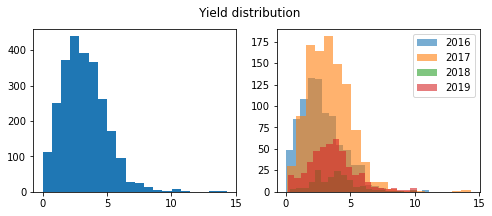

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
fig.suptitle('Yield distribution')

ax1.hist(merged_data.Yield, bins=20)

for y, df  in merged_data.groupby(['Year']):
    ax2.hist(df.Yield, bins=20, label=y, alpha=0.6) #Changes between the years
plt.legend();

In [34]:
box = pd.concat([merged_data[['Yield']], merged_data.drop(columns=['Field_ID', 'Yield', 'Year'])], axis=1)
box = box.dropna()
## calculate corr between Yield and features
box_corr = box.corr()[['Yield']][1:].reset_index().dropna().sort_values(by='Yield').rename(columns={'index':'feature', 'Yield':'CORR'}).reset_index() 

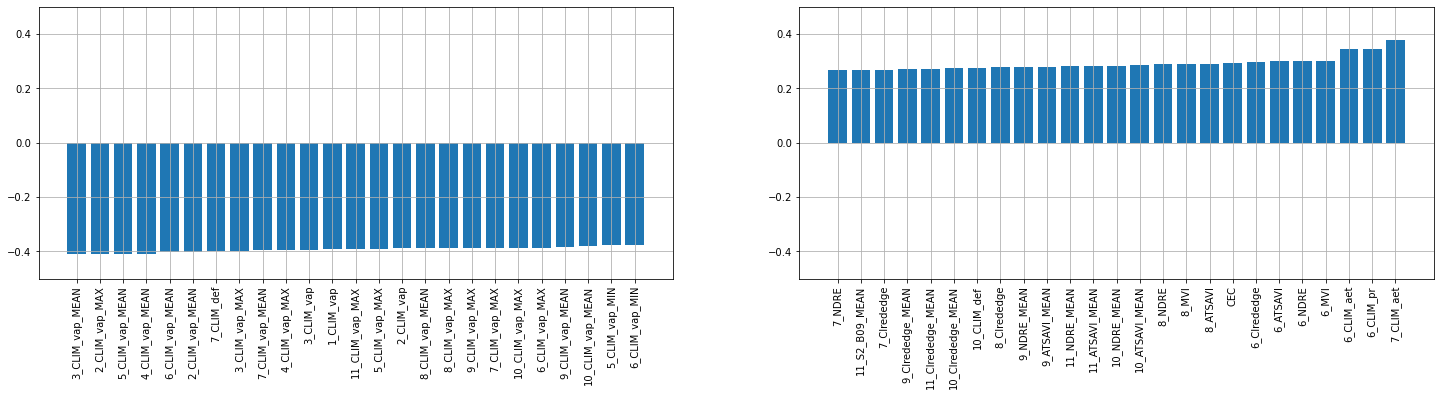

In [35]:
## show the most correlated features
n=25 
plt.figure(figsize = (25, 5))
plt.subplot(1, 2, 1)
plt.bar(box_corr.index.values[:n], box_corr.CORR.values[:n])
plt.xticks(box_corr.index.values[:n], box_corr.feature.values[:n], rotation='vertical', fontsize=10)
plt.ylim(-0.5, 0.5)
plt.grid()

plt.subplot(1, 2, 2)
plt.bar(box_corr.index.values[-n:], box_corr.CORR.values[-n:])
plt.xticks(box_corr.index.values[-n:], box_corr.feature.values[-n:], rotation='vertical', fontsize=10)
plt.ylim(-0.5, 0.5)
plt.grid()
plt.show()

# Features groups

In [36]:
features = list(merged_data.drop(columns=['Field_ID', 'Year', 'Yield']).columns.values)

In [37]:
constant_features = ['BDOD', 'CEC', 'CFVO', 'CLAY', 'NITR', 'OCD', 'OCS', 'PHH2O', 'SAND', 'SILT', 'SOC']

In [38]:
monthly_features = [f for f in features if (f not in constant_features) and ('MIN' not in f) and ('MEAN' not in f) and ('MAX' not in f)]
min_features = [f for f in features if (f not in constant_features) and ('_MIN' in f)]
mean_features = [f for f in features if (f not in constant_features) and ('_MEAN' in f)]
max_features = [f for f in features if (f not in constant_features) and ('_MAX' in f)]

In [39]:
print(len(constant_features), len(monthly_features), len(min_features), len(mean_features), len(max_features))

11 444 363 363 363


In [40]:
features_dict = {}
features_dict['const'] = constant_features
features_dict['monthly'] = monthly_features
features_dict['min'] = min_features
features_dict['mean'] = mean_features
features_dict['max'] = max_features
features_dict['corr_features'] = list(box_corr.feature.values)

In [41]:
import json
with open('./csv/features_groups.json', 'w') as file:
    json.dump(features_dict, file)

# Save data

In [42]:
data_dict = {}
data_dict['train_ids'] = list(train.Field_ID)
data_dict['test_ids'] = list(test.Field_ID)

In [43]:
years_folds_dict = {}
for y in train.Year.unique():
    years_folds_dict[int(y)] = [list(train.loc[~train.Year.isin([y])].Field_ID.values),
                           list(train.loc[train.Year.isin([y])].Field_ID.values)]

In [44]:
years_folds_dict.keys()

dict_keys([2019, 2018, 2017, 2016])

In [45]:
data_dict['year_split'] = years_folds_dict

In [46]:
with open('./csv/split.json', 'w') as file:
    json.dump(data_dict, file)

In [47]:
merged_data.to_csv('./csv/data.csv', index=False)

## Normalize data

In [48]:
merged_data_norm = merged_data.copy()
df_mean, df_std = np.nanmean(merged_data_norm[features], axis=0), np.nanstd(merged_data_norm[features], axis=0)

epsilon = 0.001
merged_data_norm[features] = (merged_data_norm[features] - df_mean) / (df_std + epsilon)


In [49]:
merged_data_norm.to_csv('./csv/data_norm.csv', index=False)